<a href="https://colab.research.google.com/github/HarleiLeite/BERTSentiment/blob/main/classify_bert_english.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Classificação de texto usando BERT

Este tutorial apresenta o código para analisar sentimentos em texto.

Você poderá:

- Treinar seu próprio modelo (exige poder computacional)
- Carregar um modelo já treinado

Boa diversão!

##Etapa 01 - Instalar as bibliotecas necessárias

In [1]:
!pip install -U "tensorflow-text==2.15.*"
!pip install -U "tf-models-official==2.15.*"

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 46.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.6 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4

##Etapa 02 - Importar as bibliotecas

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

##Etapa 03 - Carregar dataset (somente se for treinar o modelo)

Carregar em um DataFrame

In [ ]:
df = pd.read_csv('IMDBDataset.csv')
df.head(5)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


Verificar o tamanho do dataset

In [ ]:
df.shape

(50000, 2)

Verificar balanceamento de classes

In [ ]:
df['sentiment'].value_counts()

,count
sentiment,
positive,25000
negative,25000


##Etapa 04 - Pré-processamento dos dados (somente se for treinar o modelo)

Criar uma nova coluna no DataFrame chamada review_sentiment.

Mapeamento:
- review_sentiment = 1 se sentiment for positive
- review_sentiment = 0 se sentiment for negative

In [ ]:
df['review_sentiment']=df['sentiment'].apply(lambda x: 1 if x=='positive' else 0)
df.head(5)

,review,sentiment,review_sentiment
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


Dividir o dataset em treinamento (80%) e validação (20%)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['review_sentiment'], test_size=0.2)

In [ ]:
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (40000,)
X_test shape:  (10000,)
y_train shape:  (40000,)
y_test shape:  (10000,)


In [ ]:
X_train = tf.data.Dataset.from_tensor_slices({"text": X_train.values}) # Create a dict with 'text' key
y_train = tf.data.Dataset.from_tensor_slices(y_train.values)
X_test = tf.data.Dataset.from_tensor_slices({"text": X_test.values}) # Create a dict with 'text' key
y_test = tf.data.Dataset.from_tensor_slices(y_test.values)

##Etapa 05 - Importar modelo BERT (somente se for treinar o modelo)

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

map_name_to_handle = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


**Estudando o modelo de pré-processamento**

As entradas de texto precisam ser transformadas em ids de token numéricos e organizadas em vários tensores antes de serem inseridas no BERT. O TensorFlow Hub fornece um modelo de pré-processamento correspondente para cada um dos modelos BERT discutidos acima, que implementa essa transformação usando operações TF da biblioteca TF.text.

Vamos entrar com um texto qualquer para testar.

In [ ]:
#Criar o modelo de pré-processamento para testar
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_mask', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


**Estudando o BERT**

In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262885  0.99280983 -0.18611874  0.3667385   0.1523372   0.6550446
  0.9681154  -0.94862705  0.0021616  -0.9877732   0.06842716 -0.97630596]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.2894634   0.34321257  0.33231494 ...  0.21300837  0.7102077
  -0.05771141]
 [-0.28742063  0.31981015 -0.23018579 ...  0.58455044 -0.21329722
   0.72692055]
 [-0.66157013  0.6887687  -0.87433    ...  0.10877256 -0.26173246
   0.47855335]
 ...
 [-0.2256114  -0.2892561  -0.0706443  ...  0.47565973  0.83277154
   0.40025324]
 [-0.29824266 -0.27473152 -0.05450485 ...  0.48849776  1.0955359
   0.18163376]
 [-0.4437817   0.00930699  0.07223739 ...  0.17290172  1.1833248
   0.07898028]]


##Etapa 06 - Construir o modelo para classificação de texto (somente se for treinar o modelo)

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

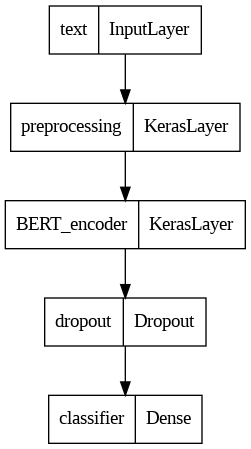

In [ ]:
classifier_model = build_classifier_model()
tf.keras.utils.plot_model(classifier_model)

##Etapa 07 - Treinamento do modelo (somente se for treinar o modelo)

**Função de perda**

Por ser um problema de classificação binária e o modelo gerar uma probabilidade, usar BinaryCrossentropy como função de perda

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

**Otimizador**

Usar o mesmo otimizador com o qual o BERT foi originalmente treinado: Adaptive Moments (AdamW).

In [ ]:
train_ds = tf.data.Dataset.zip((X_train, y_train)).batch(32) # Batch the dataset with batch size 32
test_ds = tf.data.Dataset.zip((X_test, y_test)).batch(32) # Batch the dataset with batch size 32

epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(X_train).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

**Treinamento**

Este processo pode ser demorado dependendo da configuração do computador

In [ ]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=test_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
1250/1250 [==============================] - 330s 257ms/step - loss: 0.6557 - binary_accuracy: 0.5785 - val_loss: 0.5129 - val_binary_accuracy: 0.7122
Epoch 2/5
1250/1250 [==============================] - 324s 259ms/step - loss: 0.4555 - binary_accuracy: 0.7717 - val_loss: 0.4042 - val_binary_accuracy: 0.8025
Epoch 3/5
1250/1250 [==============================] - 323s 258ms/step - loss: 0.3799 - binary_accuracy: 0.8221 - val_loss: 0.3699 - val_binary_accuracy: 0.8309
Epoch 4/5
1250/1250 [==============================] - 323s 258ms/step - loss: 0.3356 - binary_accuracy: 0.8460 - val_loss: 0.3636 - val_binary_accuracy: 0.8390
Epoch 5/5
1250/1250 [==============================] - 325s 260ms/step - loss: 0.3010 - binary_accuracy: 0.8648 - val_loss: 0.3675 - val_binary_accuracy: 0.8467


**Salvar o modelo**

Zipar a pasta do modelo para poder baixar em seu computador.

In [ ]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

In [ ]:
!zip -r /content/file.zip /content/imdb_bert/

  adding: content/imdb_bert/ (stored 0%)
  adding: content/imdb_bert/fingerprint.pb (stored 0%)
  adding: content/imdb_bert/assets/ (stored 0%)
  adding: content/imdb_bert/assets/vocab.txt (deflated 53%)
  adding: content/imdb_bert/variables/ (stored 0%)
  adding: content/imdb_bert/variables/variables.index (deflated 75%)
  adding: content/imdb_bert/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/imdb_bert/keras_metadata.pb (deflated 85%)
  adding: content/imdb_bert/saved_model.pb (deflated 92%)


##Etapa 08 - Teste do modelo

A função abaixo testa o modelo com um vetor de sentenças.

In [3]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

Se você treinou o modelo, utilize o código abaixo para testar.

In [ ]:
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the model in memory:
input: this is such an amazing movie! : score: 0.997536
input: The movie was great!           : score: 0.971831
input: The movie was meh.             : score: 0.455923
input: The movie was okish.           : score: 0.030983
input: The movie was terrible...      : score: 0.001566



Se você carregou o modelo treinado, utilize o código abaixo para testar

**Importante**: Carregar o arquivo imdb_bert.zip antes de executar.

In [4]:
!unzip imdb_bert.zip

Archive:  imdb_bert.zip
   creating: imdb_bert/
   creating: imdb_bert/assets/
  inflating: imdb_bert/assets/vocab.txt  
  inflating: imdb_bert/fingerprint.pb  
  inflating: imdb_bert/keras_metadata.pb  
  inflating: imdb_bert/saved_model.pb  
   creating: imdb_bert/variables/
  inflating: imdb_bert/variables/variables.data-00000-of-00001  
  inflating: imdb_bert/variables/variables.index  


In [6]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

reloaded_model = tf.saved_model.load(saved_model_path)
reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.997536
input: The movie was great!           : score: 0.971831
input: The movie was meh.             : score: 0.455923
input: The movie was okish.           : score: 0.030983
input: The movie was terrible...      : score: 0.001566

